## Visualization 1: GIS data from City of Toronto's open data set ##

In [2]:
# importing the main libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import plotly.graph_objects as go
import plotly.express as px
from dash import Dash, dcc, html, Input, Output
import datetime

In [3]:
pd.set_option("display.max_colwidth", None)

In [8]:
# load data
# source: https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/traffic-volumes-at-intersections-for-all-modes/resource/262469c2-abfe-4756-9068-4ea5c7ba1af7
df = pd.read_csv("tmc_raw_data_2020_2029.csv")
# select columuns from the orginal data
sel_columns = []
print(df.columns)

Index(['_id', 'count_id', 'count_date', 'location_name', 'longitude',
       'latitude', 'centreline_type', 'centreline_id', 'px', 'start_time',
       'end_time', 'n_appr_cars_r', 'n_appr_cars_t', 'n_appr_cars_l',
       's_appr_cars_r', 's_appr_cars_t', 's_appr_cars_l', 'e_appr_cars_r',
       'e_appr_cars_t', 'e_appr_cars_l', 'w_appr_cars_r', 'w_appr_cars_t',
       'w_appr_cars_l', 'n_appr_truck_r', 'n_appr_truck_t', 'n_appr_truck_l',
       's_appr_truck_r', 's_appr_truck_t', 's_appr_truck_l', 'e_appr_truck_r',
       'e_appr_truck_t', 'e_appr_truck_l', 'w_appr_truck_r', 'w_appr_truck_t',
       'w_appr_truck_l', 'n_appr_bus_r', 'n_appr_bus_t', 'n_appr_bus_l',
       's_appr_bus_r', 's_appr_bus_t', 's_appr_bus_l', 'e_appr_bus_r',
       'e_appr_bus_t', 'e_appr_bus_l', 'w_appr_bus_r', 'w_appr_bus_t',
       'w_appr_bus_l', 'n_appr_peds', 's_appr_peds', 'e_appr_peds',
       'w_appr_peds', 'n_appr_bike', 's_appr_bike', 'e_appr_bike',
       'w_appr_bike'],
      dtype='object')


In [18]:
# convert date/time columns
df['count_date'] = pd.to_datetime(df['count_date'])
df['start_time'] = pd.to_datetime(df['start_time']).dt.strftime("%H:%M")
df['end_time'] = pd.to_datetime(df['end_time'])
# df["start_hour"] =
# print(df.columns)
# print(df.info())
# print(df.head())
print(df["start_time"].unique())

['07:30' '07:45' '08:00' '08:15' '08:30' '08:45' '09:00' '09:15' '10:00'
 '10:15' '10:30' '10:45' '11:00' '11:15' '11:30' '11:45' '13:00' '13:15'
 '13:30' '13:45' '14:00' '14:15' '14:30' '14:45' '16:00' '16:15' '16:30'
 '16:45' '17:00' '17:15' '17:30' '17:45' '12:00' '12:15' '12:30' '12:45'
 '15:00' '15:15' '15:30' '06:15' '06:30' '19:30' '07:15' '18:30' '18:45'
 '18:15' '19:45' '19:00' '09:30' '09:45' '06:00' '06:45' '07:00' '15:45'
 '19:15' '18:00' '20:30' '21:15' '22:00' '22:15' '22:30' '21:45' '20:00'
 '20:45' '21:30' '22:45' '20:15' '21:00' '23:15' '23:00' '00:30' '01:00'
 '03:15' '03:30' '23:30' '00:00' '03:00' '04:15' '05:15' '23:45' '01:15'
 '01:45' '02:00' '02:15' '02:45' '04:45' '00:45' '05:00' '05:45' '02:30'
 '04:30' '00:15' '01:30' '03:45' '04:00' '05:30']


In [20]:
# get unique values for understanding the data
street_names = df["location_name"].unique()
print(street_names)
print(len(street_names))
# --------------
dates = df["count_date"].dt.strftime("%Y-%m-%d")
print(dates)
print(len(dates))
# --------------
# start_times = df["start_time"].dt.strftime("%H:%M")
# print(start_times)
# print(len(start_times))
# --------------
end_times = df["end_time"].dt.strftime("%H:%M")
print(end_times)
print(len(end_times))
# --------------

['Erindale Ave / Broadview Ave / Broadview Subway Station Parkette Trl'
 'Islington Ave / Market Garden Mews' 'Indian Valley Cres / Indian Grv'
 ... 'Markham Rd / Steeles Ave E' 'Steeles Ave E to Staines Rd'
 'Steeles Ave E / Pickering Town Line']
3580
0         2020-01-08
1         2020-01-08
2         2020-01-08
3         2020-01-08
4         2020-01-08
             ...    
272222    2024-10-26
272223    2024-10-26
272224    2024-10-26
272225    2024-10-26
272226    2024-10-26
Name: count_date, Length: 272227, dtype: object
272227
0         07:45
1         08:00
2         08:15
3         08:30
4         08:45
          ...  
272222    13:15
272223    15:45
272224    16:00
272225    18:15
272226    07:00
Name: end_time, Length: 272227, dtype: object
272227


In [ ]:
# find coordinates of each location and save that to a dataframe
# ****** THIS CODE TAKES TIME TO COMPLETE - THE DATAFRAME IS ALREADY SAVED, PROCEED TO THE NEXT CELL! ****
# --------------
cars_traffic_columns = ["n_appr_cars_r","n_appr_cars_l","n_appr_cars_t",
                       "s_appr_cars_r","s_appr_cars_l","s_appr_cars_t",
                       "e_appr_cars_r","e_appr_cars_l","e_appr_cars_t",
                       "w_appr_cars_r","w_appr_cars_l","w_appr_cars_t"]
peds_traffic_columns = ["n_appr_peds","s_appr_peds","e_appr_peds","w_appr_peds"]
bikes_traffic_columns = ["n_appr_bike","s_appr_bike","e_appr_bike","w_appr_bike"]
street_coords = []
grouped = df.groupby(["location_name"])
for name,grp in grouped:
    longitude = grp["longitude"].unique()[0]
    latitude = grp["latitude"].unique()[0]
    location = name[0]
#     ---------------
    car_traffic = grp.groupby(["start_time"])[["start_time"]+cars_traffic_columns].apply(lambda x: pd.DataFrame({
        "cars":x[cars_traffic_columns].mean(axis=1)}).reset_index(drop=True),
                                                    include_groups=True).pivot_table(columns="start_time")
    # print(car_traffic)
    mean_cars = car_traffic.mean(axis=1).rename({"cars":"mean"})
    # print(mean_cars)
#     ---------------
    peds_traffic = grp.groupby(["start_time"])[["start_time"]+peds_traffic_columns].apply(lambda x: pd.DataFrame({
        "peds":x[peds_traffic_columns].mean(axis=1)}).reset_index(drop=True),
                                                    include_groups=True).pivot_table(columns="start_time")
    mean_peds = peds_traffic.mean(axis=1).rename({"peds":"mean"})
#     ---------------
    bikes_traffic = grp.groupby(["start_time"])[["start_time"]+bikes_traffic_columns].apply(lambda x: pd.DataFrame({
        "bikes":x[bikes_traffic_columns].mean(axis=1)}).reset_index(drop=True),
                                                    include_groups=True).pivot_table(columns="start_time")
    mean_bikes = bikes_traffic.mean(axis=1).rename({"bikes":"mean"})
#     ---------------
    # print(name[0],longitude,latitude)
    street_coords.append({"location":location,"longitude":longitude,"latitude":latitude,
                          "cars_mean":mean_cars["mean"],
                          "peds_mean":mean_peds["mean"],
                          "bikes_mean":mean_bikes["mean"]
                         })
    # print(street_coords)
    # input("press_key")
# print(street_coords)
print(len(street_coords))
street_coords = pd.DataFrame(street_coords)
print(street_coords.head())
street_coords.to_csv("street_coords.csv")

In [24]:
# load the processed dataframe and generate an interactive plot
street_coords = pd.read_csv("street_coords.csv")
fig = px.scatter_map(
    street_coords,
    lat="latitude",
    lon="longitude",
    hover_name="location",
    hover_data=["cars_mean", "peds_mean","bikes_mean"],
    color_discrete_sequence=["#de33dd"],
    zoom=3,
    height=400
)
fig.update_layout(title="Traffic Volumes at Toronto City Intersections",title_x=0.5,
                 font = {"family":"Arial","size":18,"color":"black"})
fig.update_layout(map_style="open-street-map")
fig.update_layout(margin={"r": 0,  "l": 1, "b": 0})
fig.update_layout(map_bounds={"west": -80, "east": -78.6, "south": 0, "north": 50})
# fig.write_html("visualization_assignment_3.html")
fig.show()

## Visualization 2: Average traffic at street intrsections ##

In [9]:
# visualization 2
# timeseries visualzation for each street averaged across all the days
print(df.head(n=5))
print(df.info())
# create the averaged dataframe
grouped = df.groupby(["location_name","start_time"])
df_avg = pd.DataFrame()
for name,group in grouped:
    # print(name)
    # print(group)
    avg_cars = group["n_appr_cars_r"].mean() 
    + group["n_appr_cars_l"].mean()
    + group["n_appr_cars_t"].mean()
    + group["s_appr_cars_r"].mean()
    + group["s_appr_cars_l"].mean()
    + group["s_appr_cars_t"].mean()
    + group["e_appr_cars_r"].mean()
    + group["e_appr_cars_l"].mean()
    + group["e_appr_cars_t"].mean()
    + group["w_appr_cars_r"].mean()
    + group["w_appr_cars_l"].mean()
    + group["w_appr_cars_t"].mean()
        
    avg_peds = group["n_appr_peds"].mean()
    + group["s_appr_peds"].mean()
    + group["e_appr_peds"].mean()
    + group["w_appr_peds"].mean()
    df_temp = pd.DataFrame.from_dict({"location_name":group["location_name"].unique(),
               "start_time":group["start_time"].unique(),
               "avg_cars":avg_cars,
               "avg_peds":avg_peds
              })
    df_avg = pd.concat((df_avg,df_temp))
    # print(df_avg)
    # print(avg_cars,avg_peds)
    # input("press")
print(df_avg.head())
df_avg.to_csv("averaged_cars_peds_per_location_timeof_the_day.csv")

   _id  count_id  count_date  \
0    1     39337  2020-01-08   
1    2     39337  2020-01-08   
2    3     39337  2020-01-08   
3    4     39337  2020-01-08   
4    5     39337  2020-01-08   

                                       location_name  longitude   latitude  \
0  Erindale Ave / Broadview Ave / Broadview Subwa... -79.358652  43.677521   
1  Erindale Ave / Broadview Ave / Broadview Subwa... -79.358652  43.677521   
2  Erindale Ave / Broadview Ave / Broadview Subwa... -79.358652  43.677521   
3  Erindale Ave / Broadview Ave / Broadview Subwa... -79.358652  43.677521   
4  Erindale Ave / Broadview Ave / Broadview Subwa... -79.358652  43.677521   

   centreline_type  centreline_id  px           start_time  ... w_appr_bus_t  \
0                2       13462138 NaN  2020-01-08T07:30:00  ...            0   
1                2       13462138 NaN  2020-01-08T07:45:00  ...            0   
2                2       13462138 NaN  2020-01-08T08:00:00  ...            0   
3                2

In [ ]:
# print(df_avg.head())
# fh = plt.figure()
# ah = fh.add_subplot()
# for name, group in df_avg.groupby(["location_name"]):
#     ax = group.plot(ax = ah, x= "start_time",y= "avg_cars",kind = "line",label=name)
#     print(name)
# plt.legend(loc = "best")
# plt.show()

In [13]:
print(len(df_avg["location_name"].unique()))

3580


NameError: name 'mdates' is not defined

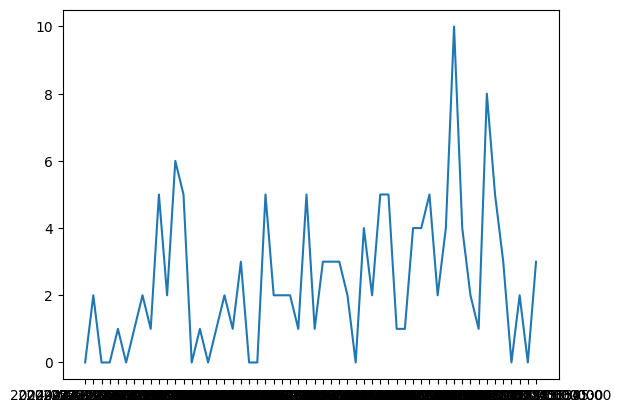

In [14]:
# ploting for testing purpose
fh = plt.figure()
ax = fh.add_subplot(111)
loc_id = 100
x = df_avg.loc[df_avg["location_name"] == df_avg["location_name"].unique()[loc_id],"start_time"]
y = df_avg.loc[df_avg["location_name"] == df_avg["location_name"].unique()[loc_id],"avg_cars"].to_numpy()
ax.plot(x,y,"-")
from matplotlib.ticker import AutoLocator
# print(x)
# Set major ticks every 4 hours
ax.xaxis.set_major_locator(mdates.HourLocator(interval=50))
ax.tick_params(axis='x', rotation=45)

In [ ]:
df_avg.sort_values(by=["start_time"],inplace=True)

In [ ]:
fh = plt.figure(figsize=(10,5))
ax = fh.add_subplot(111)
np.random.seed(42)
N = 70 # Select a random sample of street intersections
var1_name = "avg_cars"
var2_name = "avg_peds"
# var_name = "avg_peds"
all_locations = df_avg["location_name"].unique()
sel_loc_ids = np.random.randint(0,len(locations),N)
sel_locations = [all_locations[id] for id in sel_loc_ids]
# print(sel_locations)
# --------------
# compute statistics measures for two variables (cars and pedestrains)
avg_car_traffic = df_avg[df_avg["location_name"].isin(sel_locations)][["start_time",var1_name]].groupby(["start_time"]).apply(np.mean,axis=0)
std_car_traffic = df_avg[df_avg["location_name"].isin(sel_locations)][["start_time",var1_name]].groupby(["start_time"]).apply(np.std,axis=0)
sem_car_traffic = std_car_traffic/np.sqrt(N)
# --------------
avg_ped_traffic = df_avg[df_avg["location_name"].isin(sel_locations)][["start_time",var2_name]].groupby(["start_time"]).apply(np.mean,axis=0)
std_ped_traffic = df_avg[df_avg["location_name"].isin(sel_locations)][["start_time",var2_name]].groupby(["start_time"]).apply(np.std,axis=0)
sem_ped_traffic = std_ped_traffic/np.sqrt(N)
# --------------
# print(avg_car_traffic)
# print(std_car_traffic)
# print(sem_car_traffic)
# input("key")
# plot individual street traffics
for i in loc_ids:
    loc = locations[i]
    x_car = df_avg.loc[df_avg["location_name"] == loc,"start_time"].to_numpy()
    y_car = df_avg.loc[df_avg["location_name"] == loc,var1_name].to_numpy()
    # print(x)
    # print(y)
    if(y_car.sum() == 0):
        continue
    ax.plot(x_car,y_car,linestyle="-",linewidth=0.5,color="red",alpha=0.2)
# ax.plot(avg_car_traffic)
# -----------------
ax.errorbar(x=avg_car_traffic.index.values,y=avg_car_traffic[var1_name],yerr=sem_car_traffic[var1_name],label="Car Traffic",color="red")
ax.errorbar(x=avg_ped_traffic.index.values,y=avg_ped_traffic[var2_name],yerr=sem_ped_traffic[var2_name],label="Pedestrain Traffic",color="blue")
# -----------------
ax.xaxis.set_major_locator(mdates.HourLocator(interval=150))
ax.tick_params(axis='x', rotation=45)
ax.set_ylim([0,30])
ax.set_title("Car Traffic at Toronto Street Intersections",fontsize=16)
ax.set_xlabel("Time of the day (HH:MM)",fontsize=14)
ax.set_ylabel("Traffic at every 15 minutes",fontsize=12)

ax.annotate("School rush",xycoords="axes fraction", xy = [0.1,0.35], xytext = [0.12,0.37],arrowprops = dict(arrowstyle = 'fancy'),rotation=45,color= "black")
ax.annotate("Office rush",xycoords="axes fraction", xy = [0.25,0.45], xytext = [0.27,0.47],arrowprops = dict(arrowstyle = 'fancy'),rotation=45,color= "black")
ax.annotate("Afternoon rush",xycoords="axes fraction", xy = [0.4,0.45], xytext = [0.42,0.47],arrowprops = dict(arrowstyle = 'fancy'),rotation=45,color= "black")
ax.annotate("After work rush",xycoords="axes fraction", xy = [0.71,0.45], xytext = [0.73,0.47],arrowprops = dict(arrowstyle = 'fancy'),rotation=45,color= "black")
ax.legend()
plt.show()

In [ ]:
plt.save("toronto_city_traffic_2.png")